In [2]:
import tensorflow
from  tensorflow import keras
print('TensorFlow version:',tensorflow.__version__)
print('Keras version:',keras.__version__)

TensorFlow version: 2.17.0
Keras version: 3.6.0


2 classes:
['Benign', 'Malignant']


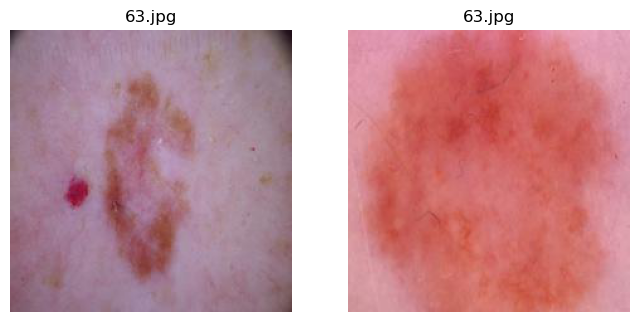

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
%matplotlib inline

# The images are in the data/shapes folder
data_folder = 'Cancer/train'

# Get the class names
classes = os.listdir(data_folder)
classes.sort()
print(len(classes), 'classes:')
print(classes)

# Show the first image in each folder
fig = plt.figure(figsize=(8, 12))
i = 0
for sub_dir in os.listdir(data_folder):
    i+=1
    img_file = os.listdir(os.path.join(data_folder,sub_dir))[0]
    img_path = os.path.join(data_folder, sub_dir, img_file)
    img = mpimg.imread(img_path)
    a=fig.add_subplot(1, len(classes),i)
    a.axis('off')
    imgplot = plt.imshow(img)
    a.set_title(img_file)
plt.show()

In [59]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (128, 128)
batch_size = 32

print("Getting Data...")

# Aplicar data augmentation con rotación, desplazamiento, zoom, etc.
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.3
)

#datagen = ImageDataGenerator(rescale=1./255, # normalize pixel values
#                             validation_split=0.3) # hold back 30% of the images for validation

print("Preparing training dataset...")
train_generator = datagen.flow_from_directory(
    data_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

print("Preparing validation dataset...")
validation_generator = datagen.flow_from_directory(
    data_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

classnames = list(train_generator.class_indices.keys())
print('Data generators ready')

Getting Data...
Preparing training dataset...
Found 8316 images belonging to 2 classes.
Preparing validation dataset...
Found 3563 images belonging to 2 classes.
Data generators ready


In [76]:
# Define a CNN classifier network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.regularizers import l1
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD

# Define the model as a sequence of layers
model = Sequential()

# The input layer accepts an image and applies a convolution that uses 32 6x6 filters and a rectified linear unit activation function
model.add(Conv2D(32, (3, 3), input_shape=(128, 128, 3), activation='relu'))

# Next we'll add a max pooling layer with a 2x2 patch
model.add(MaxPooling2D(pool_size=(2,2)))

# We can add as many layers as we think necessary - here we'll add another convolution and max pooling layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# And another set
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# A dropout layer randomly drops some nodes to reduce inter-dependencies (which can cause over-fitting)
#model.add(Dropout(0.2))

# Flatten the feature maps 
model.add(Flatten())

model.add(Dense(100, activation='relu'))
# Generate a fully-connected output layer with a predicted probability for each class
# (softmax ensures all probabilities sum to 1)
model.add(Dense(2, activation='softmax'))


# With the layers defined, we can now compile the model for categorical (multi-class) classification
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(learning_rate=0.01),
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 100)            │     2,508,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,602,350 (9.93 MB)

 Trainable params: 2,602,350 (9.93 MB)

 Non-trainable params: 0 (0.00 B)

None


In [79]:
# Train the model over 5 epochs using 30-image batches and using the validation holdout dataset for validation
num_epochs = 5
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = num_epochs)

Epoch 1/5
259/259 ━━━━━━━━━━━━━━━━━━━━ 56s 217ms/step - accuracy: 0.8043 - loss: 0.4324 - val_accuracy: 0.7706 - val_loss: 0.4815
Epoch 2/5
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 110us/step - accuracy: 0.8438 - loss: 0.3381 - val_accuracy: 0.7273 - val_loss: 0.4694
Epoch 3/5
259/259 ━━━━━━━━━━━━━━━━━━━━ 61s 237ms/step - accuracy: 0.8160 - loss: 0.3973 - val_accuracy: 0.7244 - val_loss: 0.5896
Epoch 4/5
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 123us/step - accuracy: 0.8125 - loss: 0.4242 - val_accuracy: 0.7273 - val_loss: 0.5733
Epoch 5/5
259/259 ━━━━━━━━━━━━━━━━━━━━ 64s 246ms/step - accuracy: 0.8309 - loss: 0.3844 - val_accuracy: 0.7652 - val_loss: 0.4804


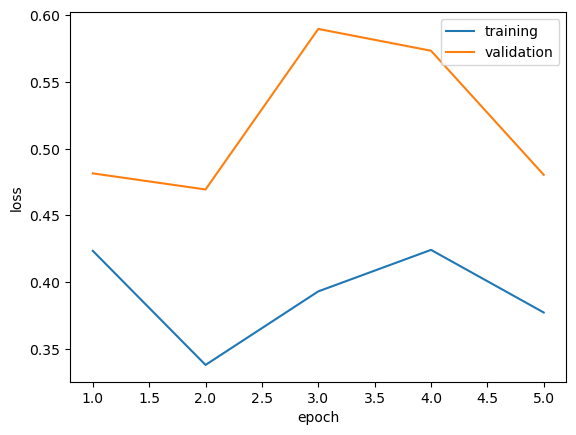

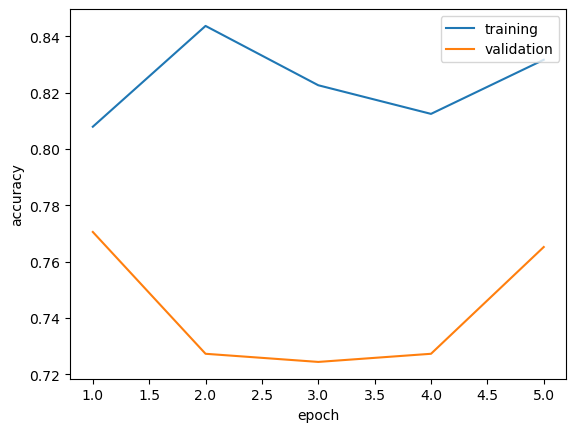

In [80]:
%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()


epoch_nums = range(1,num_epochs+1)
training_accuracy = history.history["accuracy"]
validation_accuracy = history.history["val_accuracy"]
plt.plot(epoch_nums, training_accuracy)
plt.plot(epoch_nums, validation_accuracy)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

Generating predictions from validation data...
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step


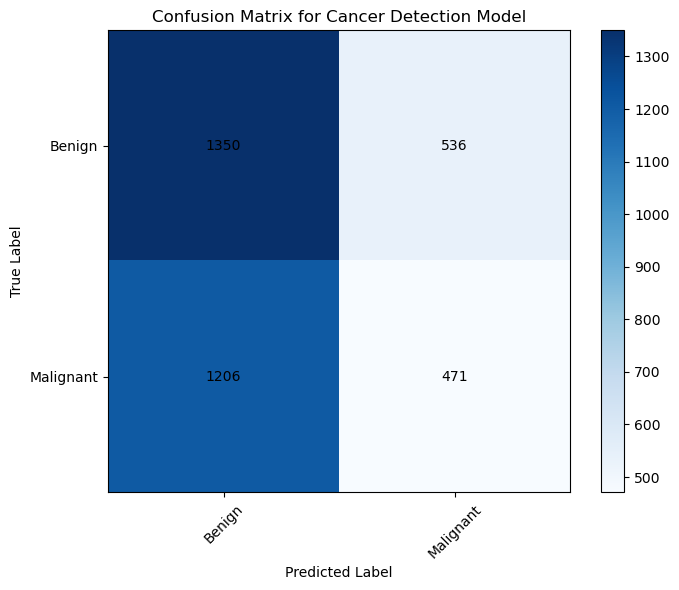

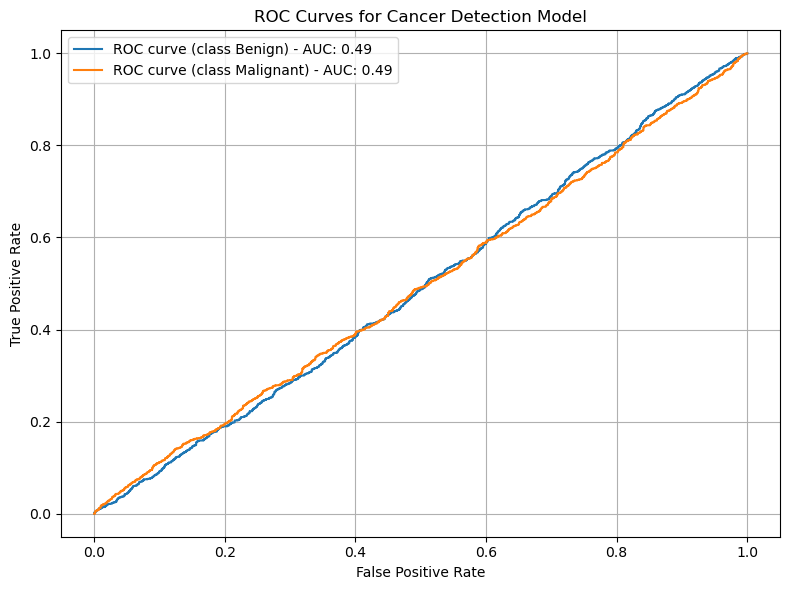

In [35]:
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Genera predicciones a partir de los datos de validación
print("Generating predictions from validation data...")

# Obtén todas las predicciones de validación
predictions = model.predict(validation_generator)

# La salida del modelo son probabilidades, así que obtenemos las clases predichas
predicted_classes = np.argmax(predictions, axis=1)

# Obtén las etiquetas verdaderas de todos los datos de validación
true_labels = validation_generator.classes  # Esto obtiene las etiquetas verdaderas

# Crea la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_classes)

# ------------------ Gráfico 1: Matriz de Confusión ------------------ #
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Cancer Detection Model")
plt.xticks(np.arange(len(classnames)), classnames, rotation=45)
plt.yticks(np.arange(len(classnames)), classnames)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Etiquetas dentro de la matriz de confusión
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[0])):
        plt.text(j, i, str(conf_matrix[i, j]), ha="center", va="center", color="black")

plt.colorbar()


# ------------------ Gráfico 2: Curva ROC ------------------ #
# Asegúrate de que tienes las probabilidades para la clase positiva
predicted_probabilities = predictions  # Probabilidades del modelo para todas las clases
fpr, tpr, roc_auc = {}, {}, {}

# Suponiendo que hay dos clases (0 y 1)
for i in range(len(classnames)):
    fpr[i], tpr[i], _ = roc_curve(true_labels, predicted_probabilities[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Grafica la curva ROC
plt.figure(figsize=(8, 6))
for i in range(len(classnames)):
    plt.plot(fpr[i], tpr[i], linestyle='-', label=f'ROC curve (class {classnames[i]}) - AUC: {roc_auc[i]:.2f}')

plt.title('ROC Curves for Cancer Detection Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.grid()

plt.tight_layout()
plt.show()  